In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm import tqdm

data = pd.read_csv('/kaggle/input/earthquake-time-vs-velocity-dataset/space_app_not_continuous.csv')

data

,data,p_wave_arrival,time
0,0.011564,300.0,0.00
1,0.012698,300.0,0.25
2,0.012159,300.0,0.50
3,0.013744,300.0,0.75
4,0.013187,300.0,1.00
...,...,...,...
59698396,0.005810,0.0,14924599.00
59698397,0.009254,0.0,14924599.25
59698398,0.005633,0.0,14924599.50
59698399,0.008816,0.0,14924599.75


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
data = data[['p_wave_arrival','time','data']]
data

,p_wave_arrival,time,data
0,300.0,0.00,0.011564
1,300.0,0.25,0.012698
2,300.0,0.50,0.012159
3,300.0,0.75,0.013744
4,300.0,1.00,0.013187
...,...,...,...
59698396,0.0,14924599.00,0.005810
59698397,0.0,14924599.25,0.009254
59698398,0.0,14924599.50,0.005633
59698399,0.0,14924599.75,0.008816


In [4]:
idx = int(59698401/5)
idx

11939680

In [5]:
shifted_df = data[:idx]

In [6]:
shifted_df[-60000:]

,p_wave_arrival,time,data
11879680,2971066.75,2969920.00,0.418395
11879681,2971066.75,2969920.25,0.421770
11879682,2971066.75,2969920.50,0.420537
11879683,2971066.75,2969920.75,0.423720
11879684,2971066.75,2969921.00,0.422458
...,...,...,...
11939675,2985266.75,2984918.75,-0.060091
11939676,2985266.75,2984919.00,-0.059706
11939677,2985266.75,2984919.25,-0.060011
11939678,2985266.75,2984919.50,-0.059657


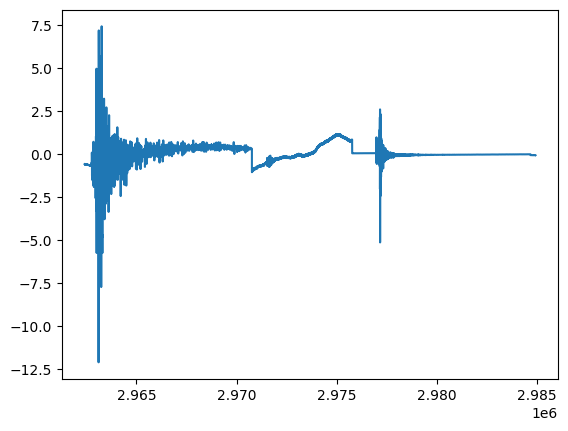

In [7]:
import matplotlib.pyplot as plt
plt.plot(shifted_df[-90000:].time,shifted_df[-90000:].data)

In [8]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 3.00000000e+02,  0.00000000e+00,  1.15641236e-02],
       [ 3.00000000e+02,  2.50000000e-01,  1.26982391e-02],
       [ 3.00000000e+02,  5.00000000e-01,  1.21591066e-02],
       ...,
       [ 2.98526675e+06,  2.98491925e+06, -6.00114964e-02],
       [ 2.98526675e+06,  2.98491950e+06, -5.96572625e-02],
       [ 2.98526675e+06,  2.98491975e+06, -6.00802073e-02]])

In [9]:
shifted_df_as_np.shape

(11939680, 3)

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((11939680, 2), (11939680,))

In [11]:
shifted_df.data.mean()

-0.0029941329537829693

In [12]:
prev = 5
nxt = 20
mul = 10
ln = len(X)
ls = []
for i in tqdm(range(len(X))):
    tem = []
    for j in range(1,prev+1):
        vl = i-mul*j
        if(vl>-1):
            tem.append(X[vl])
        else:
            tem.append([shifted_df.time.mean(),shifted_df.data.mean()])
    tem = tem[::-1]
    tem.append(X[i])
    for j in range(1,nxt+1):
        vl = i+mul*j
        if(vl<ln):
            tem.append(X[vl])
        else:
            tem.append([shifted_df.time.mean(),shifted_df.data.mean()])
    ls.append(np.array(tem))
    ls[:2]

100%|██████████| 11939680/11939680 [08:01<00:00, 24797.48it/s]


In [13]:
from copy import deepcopy as dc
# X = dc(np.flip(X, axis=1))
X = np.array(ls)
y[:10]

array([300., 300., 300., 300., 300., 300., 300., 300., 300., 300.])

In [14]:
split_index = int(len(X) * 0.95)

split_index

11342696

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11342696, 26, 2), (596984, 26, 2), (11342696,), (596984,))

In [16]:
# lookback=2
# X_train = X_train.reshape((-1, lookback, 1))
# X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11342696, 26, 2), (596984, 26, 2), (11342696, 1), (596984, 1))

In [17]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([11342696, 26, 2]),
 torch.Size([596984, 26, 2]),
 torch.Size([11342696, 1]),
 torch.Size([596984, 1]))

In [18]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [19]:
train_dataset

In [20]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 26, 2]) torch.Size([128, 1])


In [22]:
import torch
import torch.nn as nn

class FullyConnectedNNWithCNN(nn.Module):
    def __init__(self, timessteps):
        super(FullyConnectedNNWithCNN, self).__init__()
        
        self.timessteps = timessteps
        # Dropout layer with 0.1 probability
        self.dropout = nn.Dropout(p=0.1)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(self.timessteps * 2, 256)  # Flatten input: 26 timesteps * 2 features = 52
        self.fc2 = nn.Linear(256, 512 * self.timessteps)  # Ensure output has the correct size for reshaping
        
        # 1D Convolutional Layer with kernel size = 5, input channels = 512, output channels = 256
        self.conv1d = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=5, padding=2)
        
        # Continue with fully connected layers
        self.fc3 = nn.Linear(256 * self.timessteps, 256)  # After Conv1d, we flatten it again
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 8)
        self.fc6 = nn.Linear(8, 1)  # Output layer for regression
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input from (batch_size, 26, 2) to (batch_size, 52)
        x = x.view(x.size(0), -1)
        
        # Pass through the first two fully connected layers with ReLU activations
        x = self.relu(self.fc1(x))  # Input -> 256 neurons
        x = self.relu(self.fc2(x))  # 256 -> 512*26 neurons
        
        # Reshape for 1D convolution: (batch_size, 512, 26) for time dimension
        x = x.view(x.size(0), 512, self.timessteps)
        
        # Pass through the Conv1d layer
        x = self.conv1d(x)  # Apply 1D CNN
        x = self.relu(x)
        
        # Flatten again after Conv1d to pass to fully connected layers
        x = x.view(x.size(0), -1)  # (batch_size, 256 * 26)
        
        # Continue through the rest of the fully connected layers
        x = self.relu(self.fc3(x))  # 256*26 -> 256 neurons
        x = self.relu(self.fc4(x))  # 256 -> 64 neurons
        x = self.relu(self.fc5(x))  # 64 -> 8 neurons
        x = self.fc6(x)  # 8 -> 1 neuron (output layer, no activation for regression)
        
        return x


# Example usage
timessteps = 26
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConnectedNNWithCNN(timessteps).to(device)

# Input: Batch of 128 samples, each with 26 timesteps, 2 features
input_data = torch.randn(128, 26, 2).to(device)
output = model(input_data)
print(output.size())  # Expected output size: [128, 1]

torch.Size([128, 1])


In [23]:
def save_checkpoint(checkpoint,filename):
    print(f"=> Saving checkpoint {filename}")
    print('')
    torch.save(checkpoint,filename)
    

def load_model(checkpoint):
    print("=> Loading checkpoint")
    print('')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

In [24]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in tqdm(enumerate(train_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Loss : {running_loss/len(train_loader)}')
    print()

In [25]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in tqdm(enumerate(test_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [26]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
load_model_from_prev = True
checkpointpath = '/kaggle/input/2n-1c-4n-fold1-epoch10/checkpoint10'

if(load_model_from_prev):
    print(f'Loading The Model form : {checkpointpath}')
    checkpoint = torch.load(checkpointpath)
    load_model(checkpoint)

Loading The Model form : /kaggle/input/2n-1c-4n-fold1-epoch10/checkpoint10


/tmp/ipykernel_23/451241615.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpointpath)


=> Loading checkpoint



In [28]:
for epoch in range(num_epochs):
    
    train_one_epoch()
    validate_one_epoch()
    
    if((epoch+1)%5==0):
        checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : optimizer.state_dict()}
        save_checkpoint(checkpoint,f'checkpoint{epoch+1}')

Epoch: 1


88615it [09:13, 160.07it/s]


Loss : 13702690.028211929



4664it [00:10, 456.22it/s]


Val Loss: 190418775.692
***************************************************

Epoch: 2


88615it [09:15, 159.52it/s]


Loss : 13853823.530855386



4664it [00:10, 444.25it/s]


Val Loss: 187415796.571
***************************************************

Epoch: 3


88615it [09:16, 159.36it/s]


Loss : 13313293.915936919



4664it [00:10, 451.95it/s]


Val Loss: 198874345.645
***************************************************

Epoch: 4


88615it [09:14, 159.94it/s]


Loss : 12380396.783360604



4664it [00:10, 458.54it/s]


Val Loss: 164169243.312
***************************************************

Epoch: 5


88615it [09:13, 160.00it/s]


Loss : 12295468.04536478



4664it [00:10, 456.74it/s]


Val Loss: 157926160.311
***************************************************

=> Saving checkpoint checkpoint5

Epoch: 6


88615it [09:14, 159.70it/s]


Loss : 18148138.551616542



4664it [00:10, 455.33it/s]


Val Loss: 262590879.574
***************************************************

Epoch: 7


88615it [09:14, 159.88it/s]


Loss : 13166605.16835468



4664it [00:10, 457.21it/s]


Val Loss: 218078580.459
***************************************************

Epoch: 8


88615it [09:14, 159.73it/s]


Loss : 14609352.184963042



4664it [00:10, 456.36it/s]


Val Loss: 194397449.982
***************************************************

Epoch: 9


88615it [09:14, 159.93it/s]


Loss : 13504630.960105512



4664it [00:10, 454.00it/s]


Val Loss: 174676530.150
***************************************************

Epoch: 10


88615it [09:13, 159.97it/s]


Loss : 12138865.482587598



4664it [00:10, 456.50it/s]


Val Loss: 190480671.891
***************************************************

=> Saving checkpoint checkpoint10

Epoch: 11


88615it [09:14, 159.92it/s]


Loss : 18796063.500962026



4664it [00:10, 457.11it/s]


Val Loss: 215576766.384
***************************************************

Epoch: 12


88615it [09:13, 160.11it/s]


Loss : 10462079.152493935



4664it [00:10, 458.86it/s]


Val Loss: 168694410.374
***************************************************

Epoch: 13


88615it [09:13, 160.12it/s]


Loss : 10012380.200998703



4664it [00:10, 458.55it/s]


Val Loss: 160588487.520
***************************************************

Epoch: 14


88615it [09:13, 160.09it/s]


Loss : 15513491.84699543



4664it [00:10, 458.52it/s]


Val Loss: 159968111.167
***************************************************

Epoch: 15


88615it [09:13, 160.18it/s]


Loss : 18513213.641621057



4664it [00:10, 458.26it/s]


Val Loss: 318981457.157
***************************************************

=> Saving checkpoint checkpoint15

Epoch: 16


88615it [09:13, 160.04it/s]


Loss : 26639368.487547256



4664it [00:10, 455.94it/s]


Val Loss: 215283718.171
***************************************************

Epoch: 17


88615it [09:13, 160.03it/s]


Loss : 21357131.517942786



4664it [00:10, 457.97it/s]


Val Loss: 242528843.142
***************************************************

Epoch: 18


88615it [09:13, 160.17it/s]


Loss : 15161548.471920667



4664it [00:10, 459.48it/s]


Val Loss: 209528471.232
***************************************************

Epoch: 19


88615it [09:13, 160.15it/s]


Loss : 13070326.271697793



4664it [00:10, 459.38it/s]


Val Loss: 214222413.252
***************************************************

Epoch: 20


88615it [09:12, 160.29it/s]


Loss : 12963616.571703436



4664it [00:10, 458.26it/s]


Val Loss: 248135781.253
***************************************************

=> Saving checkpoint checkpoint20

Epoch: 21


88615it [09:13, 160.23it/s]


Loss : 12508429.363476839



4664it [00:10, 458.27it/s]


Val Loss: 305712845.121
***************************************************

Epoch: 22


88615it [09:12, 160.34it/s]


Loss : 15303532.688904248



4664it [00:10, 458.11it/s]


Val Loss: 200793462.230
***************************************************

Epoch: 23


88615it [09:12, 160.25it/s]


Loss : 11957755.511290414



4664it [00:10, 456.49it/s]


Val Loss: 188146381.371
***************************************************

Epoch: 24


88615it [09:13, 160.19it/s]


Loss : 11649720.39605033



4664it [00:10, 458.71it/s]


Val Loss: 194219276.559
***************************************************

Epoch: 25


88615it [09:13, 160.23it/s]


Loss : 11508570.973088643



4664it [00:10, 458.06it/s]


Val Loss: 316751941.530
***************************************************

=> Saving checkpoint checkpoint25

Epoch: 26


88615it [09:12, 160.36it/s]


Loss : 11214525.566331886



4664it [00:10, 458.48it/s]


Val Loss: 178304770.961
***************************************************

Epoch: 27


88615it [09:12, 160.27it/s]


Loss : 11009346.264797157



4664it [00:10, 456.52it/s]


Val Loss: 178920840.002
***************************************************

Epoch: 28


88615it [09:13, 160.15it/s]


Loss : 10723294.89389776



4664it [00:10, 459.36it/s]


Val Loss: 171978723.465
***************************************************

Epoch: 29


88615it [09:13, 160.21it/s]


Loss : 10583914.325932404



4664it [00:10, 456.44it/s]


Val Loss: 181433238.272
***************************************************

Epoch: 30


88615it [09:13, 160.21it/s]


Loss : 10361132.057340743



4664it [00:10, 456.01it/s]


Val Loss: 171597092.288
***************************************************

=> Saving checkpoint checkpoint30

Epoch: 31


88615it [09:13, 160.09it/s]


Loss : 10378591.532271624



4664it [00:10, 455.05it/s]


Val Loss: 201455745.073
***************************************************

Epoch: 32


88615it [09:12, 160.29it/s]


Loss : 10492107.29886588



4664it [00:10, 456.21it/s]


Val Loss: 202474677.923
***************************************************

Epoch: 33


88615it [09:12, 160.41it/s]


Loss : 11043928.272676747



4664it [00:10, 458.09it/s]


Val Loss: 213376172.672
***************************************************

Epoch: 34


88615it [09:12, 160.31it/s]


Loss : 10376773.155806014



4664it [00:10, 458.35it/s]


Val Loss: 202968237.689
***************************************************

Epoch: 35


88615it [09:12, 160.34it/s]


Loss : 9966375.51847599



4664it [00:10, 457.87it/s]


Val Loss: 243774568.958
***************************************************

=> Saving checkpoint checkpoint35

Epoch: 36


88615it [09:13, 160.23it/s]


Loss : 10260848.5246939



4664it [00:10, 456.66it/s]


Val Loss: 205563351.245
***************************************************

Epoch: 37


88615it [09:13, 160.12it/s]


Loss : 10774668.446442476



4664it [00:10, 447.49it/s]


Val Loss: 204731470.059
***************************************************

Epoch: 38


88615it [09:13, 160.19it/s]


Loss : 10016167.57535406



4664it [00:10, 458.81it/s]


Val Loss: 239885796.930
***************************************************

Epoch: 39


88615it [09:12, 160.34it/s]


Loss : 9564728.154147154



4664it [00:10, 459.01it/s]


Val Loss: 203815775.375
***************************************************

Epoch: 40


88615it [09:12, 160.40it/s]


Loss : 9622960.904508267



4664it [00:10, 457.53it/s]


Val Loss: 215638711.963
***************************************************

=> Saving checkpoint checkpoint40

Epoch: 41


88615it [09:12, 160.31it/s]


Loss : 9700016.63091181



4664it [00:10, 458.92it/s]


Val Loss: 204371643.497
***************************************************

Epoch: 42


88615it [09:13, 160.18it/s]


Loss : 9414961.379247306



4664it [00:10, 458.19it/s]


Val Loss: 206520207.243
***************************************************

Epoch: 43


88615it [09:12, 160.42it/s]


Loss : 9866788.268241832



4664it [00:10, 456.67it/s]


Val Loss: 206974122.298
***************************************************

Epoch: 44


88615it [09:12, 160.36it/s]


Loss : 9345023.812799752



4664it [00:10, 455.93it/s]


Val Loss: 222791761.845
***************************************************

Epoch: 45


88615it [09:12, 160.40it/s]


Loss : 9345889.039953733



4664it [00:10, 457.45it/s]


Val Loss: 225248274.974
***************************************************

=> Saving checkpoint checkpoint45

Epoch: 46


88615it [09:12, 160.29it/s]


Loss : 9444220.681473227



4664it [00:10, 456.55it/s]


Val Loss: 217157823.984
***************************************************

Epoch: 47


88615it [09:13, 160.21it/s]


Loss : 9216336.02970434



4664it [00:10, 458.35it/s]


Val Loss: 211384394.514
***************************************************

Epoch: 48


88615it [09:12, 160.30it/s]


Loss : 9238128.835659876



4664it [00:10, 458.92it/s]


Val Loss: 212015239.845
***************************************************

Epoch: 49


88615it [09:12, 160.40it/s]


Loss : 9130947.718461886



4664it [00:10, 457.84it/s]


Val Loss: 211100043.974
***************************************************

Epoch: 50


88615it [09:12, 160.41it/s]


Loss : 9380186.438509282



4664it [00:10, 457.58it/s]


Val Loss: 214161405.619
***************************************************

=> Saving checkpoint checkpoint50



In [29]:
import pandas as pd
import torch
from tqdm import tqdm

# Test function with DataFrame creation
def evaluate_model(loader, model):
    model.train(False)  # Set model to evaluation mode
    running_loss = 0.0

    # Lists to store the test data, actual, and predicted p_wave_arrival
    time_list = []
    velocity_list = []
    actual_p_wave_arrival_list = []
    predicted_p_wave_arrival_list = []

    with torch.no_grad():
        for batch_index, batch in tqdm(enumerate(loader)):
            data, targets = batch[0].to(device), batch[1].to(device)

            # Reshape input for LSTM (batch_size, sequence_length, input_size)
            data = data.squeeze(1)  # Remove extra dimensions if any

            if data.dim() == 2:  # Add sequence length dimension if it's missing
                data = data.unsqueeze(1)

            # Forward pass
            outputs = model(data)

            # Calculate loss
            loss = loss_function(outputs.squeeze(), targets)
            running_loss += loss.item()

            # Move data back to CPU and convert to numpy
            data_cpu = data.squeeze().cpu().numpy()  # Get the time and velocity data
            targets_cpu = targets.cpu().numpy()  # Actual p_wave_arrival
            preds_cpu = outputs.squeeze().cpu().numpy()  # Predicted p_wave_arrival

            # Append data to lists
            time_list.extend(data_cpu[:, 0])  # Extract the 'time' column
            velocity_list.extend(data_cpu[:, 1])  # Extract the 'velocity' column
            actual_p_wave_arrival_list.extend(targets_cpu)
            predicted_p_wave_arrival_list.extend(preds_cpu)

    # Create DataFrame
    df_results = pd.DataFrame({
        'Time': time_list,
        'Velocity': velocity_list,
        'Actual_p_wave_arrival': actual_p_wave_arrival_list,
        'Predicted_p_wave_arrival': predicted_p_wave_arrival_list
    })

    # Calculate average loss across all batches
    avg_loss_across_batches = running_loss / len(loader)

    # Print results
    print(f'Average Test Loss: {avg_loss_across_batches:.4f}')
    print('***************************************************')

    return df_results


In [30]:
# Evaluate the model on the test set
tem = evaluate_model(test_loader, model)

0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
4654it [00:11, 415.68it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([120, 1])) that is different to the input size (torch.Size([120])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
4664it [00:11, 408.90it/s]


Average Test Loss: 214161569.6653
***************************************************


In [31]:
# x = tem.Time.values
# y = tem.Velocity.values
# p = tem.Actual_p_wave_arrival.unique()
# z = tem.Predicted_p_wave_arrival.unique()
# print(len(p),len(z))
tem[:-10000]

,Time,Velocity,Actual_p_wave_arrival,Predicted_p_wave_arrival
0,"[2835661.5, 0.46060288]","[2835664.0, -1.1068829]",[2841766.8],2840968.50
1,"[2835661.8, 1.1317414]","[2835664.2, -0.69407684]",[2841766.8],2840971.75
2,"[2835662.0, 1.7190607]","[2835664.5, -0.9319031]",[2841766.8],2840972.50
3,"[2835662.2, 2.3524396]","[2835664.8, -1.572397]",[2841766.8],2840972.75
4,"[2835662.5, 2.2955623]","[2835665.0, -1.342719]",[2841766.8],2840970.25
...,...,...,...,...
586979,"[2982406.2, -0.022730248]","[2982408.8, -0.023669202]",[2985266.8],2987788.75
586980,"[2982406.5, -0.022859408]","[2982409.0, -0.02379741]",[2985266.8],2987789.00
586981,"[2982406.8, -0.022911113]","[2982409.2, -0.023850145]",[2985266.8],2987789.00
586982,"[2982407.0, -0.023048576]","[2982409.5, -0.023976495]",[2985266.8],2987789.25
